### OVERVIEW

#### 1) DEFINING FEATURES

#### 2) SCORING FUNCTION

#### 3) INTERPOLATION BETWEEN TIMESTAMPS

### IMPORTS

In [4]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import copy


### SAMPLE DATA

In [5]:
with open('data/deadpool.json', 'r') as file:
    pose_data = json.load(file)

### 1) DEFINING 12 LIMBS (12 Features)

OpenCV gives us the points of certain body parts, but we want to use relative vectors to account for changes in body type.

Below, we have defined our 12 features, which correspond to the distance between the first and second element in each tuple.

In [6]:
REL_VEC_TUPS = (
    ("LEFT_WRIST", "LEFT_ELBOW"),
    ("LEFT_ELBOW", "LEFT_SHOULDER"),
    ("LEFT_SHOULDER", "RIGHT_SHOULDER"),
    ("RIGHT_WRIST", "RIGHT_ELBOW"),
    ("RIGHT_ELBOW", "RIGHT_SHOULDER"),
    ("LEFT_SHOULDER", "LEFT_HIP"),
    ("RIGHT_SHOULDER", "RIGHT_HIP"),
    ("LEFT_HIP", "RIGHT_HIP"),
    ("LEFT_HIP", "LEFT_KNEE"),
    ("LEFT_KNEE", "LEFT_ANKLE"),
    ("RIGHT_HIP", "RIGHT_KNEE"),
    ("RIGHT_KNEE", "RIGHT_ANKLE")
)

### FINDING WEIGHTS FOR FEATURES BASED ON VARIATION (SEE GRAPH OF SAMPLE FEATURE BELOW)

In [7]:
# Find weights

first_frame = pose_data[0]["frame"]

def find_normalized_relative_vec(from_landmark, to_landmark, frame):
    frame_obj = pose_data[frame - first_frame]
    fromx = frame_obj["landmarks"][from_landmark][0]
    fromy = frame_obj["landmarks"][from_landmark][1]
    fromz = frame_obj["landmarks"][from_landmark][2]
    tox = frame_obj["landmarks"][to_landmark][0]
    toy = frame_obj["landmarks"][to_landmark][1]
    toz = frame_obj["landmarks"][to_landmark][2]
    relative_vec = [tox - fromx, toy-fromy, toz-fromz]
    relative_vec_norm = np.sqrt((relative_vec[0])**2 + (relative_vec[1])**2 + (relative_vec[2])**2)
    return [relative_vec[0] / relative_vec_norm, relative_vec[1] / relative_vec_norm,relative_vec[2] / relative_vec_norm]

# format is from: to
# some keys are repeated so i should probably fix that

all_parts = ['LEFT_ANKLE', 'LEFT_ELBOW', 'LEFT_HIP', 'LEFT_KNEE', 'LEFT_SHOULDER', 'LEFT_WRIST', 'RIGHT_ANKLE', 'RIGHT_ELBOW', 'RIGHT_HIP', 'RIGHT_KNEE', 'RIGHT_SHOULDER', 'RIGHT_WRIST']




In [8]:
def find_normalized_relative_vec_from_obj(from_landmark, to_landmark, frame_obj):
    fromx = frame_obj["landmarks"][from_landmark][0]
    fromy = frame_obj["landmarks"][from_landmark][1]
    fromz = frame_obj["landmarks"][from_landmark][2]
    tox = frame_obj["landmarks"][to_landmark][0]
    toy = frame_obj["landmarks"][to_landmark][1]
    toz = frame_obj["landmarks"][to_landmark][2]
    relative_vec = [tox - fromx, toy-fromy, toz-fromz]
    relative_vec_norm = np.sqrt((relative_vec[0])**2 + (relative_vec[1])**2 + (relative_vec[2])**2)
    return [relative_vec[0] / relative_vec_norm, relative_vec[1] / relative_vec_norm,relative_vec[2] / relative_vec_norm]

def find_sim(template_frame, user_frame, weights):
    sims = [] #form at is (from_joint, to_joint, difference)
    pure_sims_array = []
    for rel_vec in REL_VEC_TUPS:
        user_vec = find_normalized_relative_vec_from_obj(rel_vec[0], rel_vec[1], template_frame)
        temp_vec = find_normalized_relative_vec_from_obj(rel_vec[0], rel_vec[1], user_frame)
        diff_dot = np.dot(np.array(user_vec), np.array(temp_vec))
        sims.append((rel_vec[0], rel_vec[1], diff_dot))
        pure_sims_array.append(diff_dot)
    
    dot_product = np.dot(pure_sims_array, weights)
    return dot_product, sims

def find_weights(pose_data_subset):
    weights = []
    for rel_vec in REL_VEC_TUPS:
        diffs = []

        from_joint = rel_vec[0]
        to_joint = rel_vec[1]

        for i in range(1, len(pose_data_subset)):
            first_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i-1)
            second_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i)
            diff_norm = np.linalg.norm(np.array(second_normed_rel_vec) - np.array(first_normed_rel_vec))
            diffs.append(diff_norm)

        weights.append(sum(diffs))
    return weights


weights = find_weights(pose_data)
    

For left_wrist to left_elbow, we have a high variation over time, so we want to weight this feature highly.

/var/folders/_5/l3pcb2dd2z1c25f6tlf6dgc40000gn/T/ipykernel_30235/3579495851.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


np.float64(107.86751436755644)

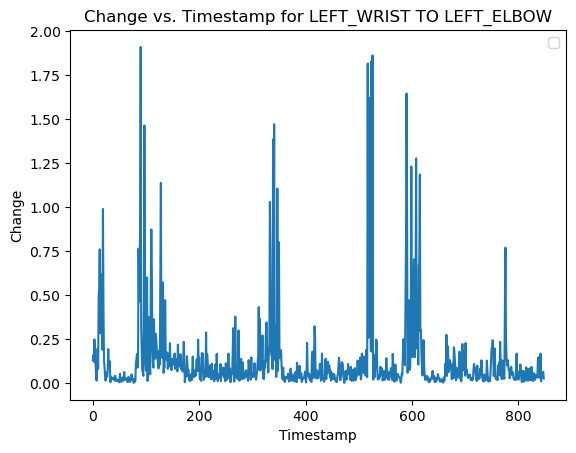

In [9]:
diffs = []

from_joint = "LEFT_WRIST"
to_joint = "LEFT_ELBOW"

for i in range(1, len(pose_data)):
    first_normed_rel_vec = find_normalized_relative_vec_from_obj(from_joint, to_joint, pose_data[i-1])
    second_normed_rel_vec = find_normalized_relative_vec_from_obj(from_joint, to_joint, pose_data[i])
    diff_norm = np.linalg.norm(np.array(second_normed_rel_vec) - np.array(first_normed_rel_vec))
    diffs.append(diff_norm)

plt.xlabel('Timestamp')  # Label for x-axis
plt.ylabel('Change')             # Label for y-axis

# Optionally, add a title and legend
plt.title('Change vs. Timestamp for LEFT_WRIST TO LEFT_ELBOW')
plt.legend()


plt.plot(diffs)
sum(diffs)

### 2) SCORING FUNCTION

First, for each feature, we calculate the actual vs expected vector, using cosine similarity (to get the value between 0 and 1)

Then, we multiply by the weights for each feature.

In [10]:
def calculate_vectors(expected, actual):

    exp_and_actual_vec = {}

    for key in REL_VEC_TUPS:
        expected_vector = (np.array(expected[key[0]]) - np.array(expected[key[1]]))
        actual_vector = (np.array(actual[key[0]]) - np.array(actual[key[1]]))
        exp_and_actual_vec[key] = [(expected_vector, actual_vector)]

    return exp_and_actual_vec

#calculate_vectors(pose_data[0]['landmarks'], pose_data[100]['landmarks'])

In [11]:
# expected_frames: list of dictionaries of lists

def calculate_norm(expected_frames, actual_frames, weights):

    total = np.array([])

    for i in range(len(expected_frames)):
        vectors = calculate_vectors(expected_frames[i], actual_frames[i])

        list_of_diffs = np.array([])

        for num, key in enumerate(REL_VEC_TUPS):
            vector1 = vectors[key][0][0]
            vector2 = vectors[key][0][1]
            cosine_similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
            list_of_diffs = np.append(list_of_diffs, (cosine_similarity + 1)/2 * weights[num])

        avg = list_of_diffs.sum() / len(list_of_diffs)
        total = np.append(total, avg)

    return sum(total) / len(total)

### 3) INTERPOLATION

To match the frames in the input and output, we use interpolation

In [12]:

REL_VEC_TUPS = (
        ("LEFT_WRIST", "LEFT_ELBOW"),
        ("LEFT_ELBOW", "LEFT_SHOULDER"),
        ("LEFT_SHOULDER", "RIGHT_SHOULDER"),
        ("RIGHT_WRIST", "RIGHT_ELBOW"),
        ("RIGHT_ELBOW", "RIGHT_SHOULDER"),
        ("LEFT_SHOULDER", "LEFT_HIP"),
        ("RIGHT_SHOULDER", "RIGHT_HIP"),
        ("LEFT_HIP", "RIGHT_HIP"),
        ("LEFT_HIP", "LEFT_KNEE"),
        ("LEFT_KNEE", "LEFT_ANKLE"),
        ("RIGHT_HIP", "RIGHT_KNEE"),
        ("RIGHT_KNEE", "RIGHT_ANKLE")
    )

def lin_interpolate_frames(frame1, frame2, timestamp):
    output = {}
    output["timestamp"] = timestamp
    output_landmarks = {}
    landmarks = [f"{side}_{bodypart}" for side in ["LEFT", "RIGHT"] for bodypart in ["WRIST", "ELBOW", "SHOULDER", "HIP", "KNEE", "ANKLE"]]
    fraction = (timestamp - frame1["timestamp"]) / (frame2["timestamp"] - frame1["timestamp"])
    for landmark in landmarks:
        output_landmarks[landmark] = [
            frame1["landmarks"][landmark][0] + fraction * (frame2["landmarks"][landmark][0] - frame1["landmarks"][landmark][0]),
            frame1["landmarks"][landmark][1] + fraction * (frame2["landmarks"][landmark][1] - frame1["landmarks"][landmark][1]),
            frame1["landmarks"][landmark][2] + fraction * (frame2["landmarks"][landmark][2] - frame1["landmarks"][landmark][2])
        ]
    output['landmarks'] = output_landmarks
    return output

def fill_values(template_pose_data, user_pose_data):
    # Main function you want to use to interpolate a bunch at once
    # Takes in two pose data lists and creates new values so that both are defined on same timestamps
    all_timestamps_ordered = [-1]
    num_points_temp = len(template_pose_data)
    num_points_user = len(user_pose_data)
    temp_pointer = 0
    user_pointer = 0
    temp_orig_timestamps = set()
    user_orig_timestamps = set()
    while True:
        try:
            curr_temp = template_pose_data[temp_pointer]["timestamp"]
            curr_user = user_pose_data[user_pointer]["timestamp"]
        except:
            break

        if temp_pointer >= num_points_temp and all_timestamps_ordered[-1]:
            if user_pointer >= num_points_user:
                break
            if all_timestamps_ordered[-1] != curr_user:
                all_timestamps_ordered.append(curr_user)
                user_orig_timestamps.add(curr_user)
            user_pointer += 1
        elif user_pointer >= num_points_user:
            if all_timestamps_ordered[-1] != curr_temp:
                all_timestamps_ordered.append(curr_temp)
                temp_orig_timestamps.add(curr_temp)
            temp_pointer += 1                        
        elif curr_temp < curr_user:
            if all_timestamps_ordered[-1] != curr_temp:
                all_timestamps_ordered.append(curr_temp)
                temp_orig_timestamps.add(curr_temp)
            temp_pointer += 1
        else: 
            if all_timestamps_ordered[-1] != curr_user:
                all_timestamps_ordered.append(curr_user)
                user_orig_timestamps.add(curr_user)
            user_pointer += 1

    all_timestamps_ordered = all_timestamps_ordered[1:]
    
    temp_out = []
    user_out = []

    temp_new_pointer = 0
    user_new_pointer = 0

    for timestamp in all_timestamps_ordered:
        if timestamp in temp_orig_timestamps:
            temp_out.append(template_pose_data[temp_new_pointer])
            temp_new_pointer += 1
        else:
            # lin interpolate uh template_pose_data[temp_new_pointer - 1] and template_pose_data[temp_new_pointer]
            temp_out.append(lin_interpolate_frames(template_pose_data[temp_new_pointer - 1], template_pose_data[temp_new_pointer], timestamp))
        if timestamp in user_orig_timestamps:
            user_out.append(user_pose_data[user_new_pointer])
            user_new_pointer += 1
        else:
            # lin interpolate uh user_pose_data[user_new_pointer - 1] and user_pose_data[user_new_pointer]       
            user_out.append(lin_interpolate_frames(user_pose_data[user_new_pointer - 1], user_pose_data[user_new_pointer], timestamp))

    return temp_out, user_out


def find_normalized_relative_vec_from_obj(from_landmark, to_landmark, frame_obj):
    fromx = frame_obj["landmarks"][from_landmark][0]
    fromy = frame_obj["landmarks"][from_landmark][1]
    fromz = frame_obj["landmarks"][from_landmark][2]
    tox = frame_obj["landmarks"][to_landmark][0]
    toy = frame_obj["landmarks"][to_landmark][1]
    toz = frame_obj["landmarks"][to_landmark][2]
    relative_vec = [tox - fromx, toy-fromy, toz-fromz]
    relative_vec_norm = np.sqrt((relative_vec[0])**2 + (relative_vec[1])**2 + (relative_vec[2])**2)
    return [relative_vec[0] / relative_vec_norm, relative_vec[1] / relative_vec_norm,relative_vec[2] / relative_vec_norm]


def find_normalized_relative_vec(from_landmark, to_landmark, frame, pose_data):
    # prob best not to use this function, uses frames which wont work with interpolated values
    frame_obj = pose_data[frame - pose_data[0]["frame"]]
    fromx = frame_obj["landmarks"][from_landmark][0]
    fromy = frame_obj["landmarks"][from_landmark][1]
    fromz = frame_obj["landmarks"][from_landmark][2]
    tox = frame_obj["landmarks"][to_landmark][0]
    toy = frame_obj["landmarks"][to_landmark][1]
    toz = frame_obj["landmarks"][to_landmark][2]
    relative_vec = [tox - fromx, toy-fromy, toz-fromz]
    relative_vec_norm = np.sqrt((relative_vec[0])**2 + (relative_vec[1])**2 + (relative_vec[2])**2)
    return [relative_vec[0] / relative_vec_norm, relative_vec[1] / relative_vec_norm,relative_vec[2] / relative_vec_norm]

def find_weights(pose_data):
    weights = []
    for rel_vec in REL_VEC_TUPS:
        diffs = []

        from_joint = rel_vec[0]
        to_joint = rel_vec[1]

        for i in range(1, len(pose_data)):
            first_normed_rel_vec = find_normalized_relative_vec_from_obj(from_joint, to_joint, pose_data[i-1])
            second_normed_rel_vec = find_normalized_relative_vec_from_obj(from_joint, to_joint, pose_data[i])
            diff_norm = np.linalg.norm(np.array(second_normed_rel_vec) - np.array(first_normed_rel_vec))
            diffs.append(diff_norm)

        weights.append(sum(diffs))
    return weights


#### BELOW, YOU CAN SEE A DEMO OF THE SCORING FUNCTION OVERTIME:

We use a sliding window, which finds the highest grade across the given windows of actual frames.

At the beginning of the graph, we have the highest score, since we are using the same data. Then, the score gets worse as we process different movement windows.

Note: we use softmax to normalize the weights to between 0 and 1.

/var/folders/_5/l3pcb2dd2z1c25f6tlf6dgc40000gn/T/ipykernel_30235/2203717308.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


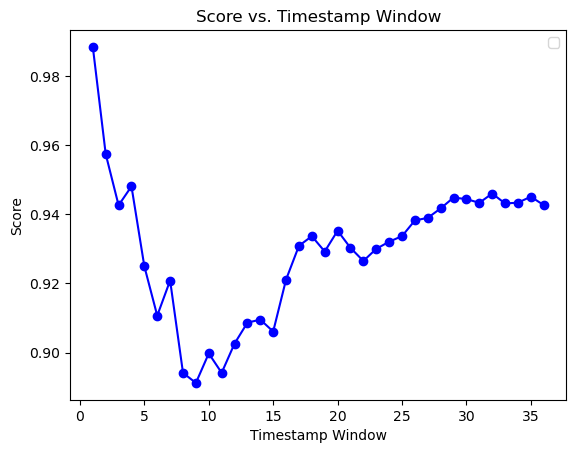

In [13]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Shift values for numerical stability
    return e_x / e_x.sum(axis=0, keepdims=True)

def calculate_grade_for_groups2(expected_movements, actual_movements):
    
    #weights = softmax(find_weights(expected_movements))
    weights =  [1 for i in range(12)]
    grade_per_timestamp_group = {}

    for i in range(len(expected_movements), len(actual_movements)):
        rang = (i-len(expected_movements), i)
        actual_movements_new_timestamps = copy.deepcopy(actual_movements[rang[0]:rang[1]])
        first_time = actual_movements_new_timestamps[0]['timestamp']
        
        for j in range(0, len(actual_movements_new_timestamps)):
            actual_movements_new_timestamps[j]['timestamp'] = actual_movements_new_timestamps[j]['timestamp'] - first_time
        
        interpolated_data = fill_values(expected_movements, actual_movements_new_timestamps)
        needed_expected_movements = [data['landmarks'] for data in interpolated_data[0]]
        needed_actual_movements = [data['landmarks'] for data in interpolated_data[1]]
        grade = calculate_norm(needed_expected_movements, needed_actual_movements, weights)
        grade_per_timestamp_group[rang] = grade

    return grade_per_timestamp_group

data = calculate_grade_for_groups2(pose_data[0:12], pose_data[0:48]).values()

x = np.arange(1, len(data) + 1)

# Add labels for the axes
plt.xlabel('Timestamp Window')  # Label for x-axis
plt.ylabel('Score')             # Label for y-axis

# Optionally, add a title and legend
plt.title('Score vs. Timestamp Window')
plt.legend()

plt.plot(x, data, marker='o', linestyle='-', color='b', label='Data')



#### THE HIGHEST SCORE WAS .988, SO WE GIVE THIS GRADE TO THE USER

In [15]:
def calculate_highest_grade(expected_movements, actual_movements):
    return max(list(calculate_grade_for_groups2(expected_movements, actual_movements).values()))

calculate_highest_grade(pose_data[0:12], pose_data[0:48])

np.float64(0.9883951353256711)